#**FACE RECOGNITION**

---
BPNN Matrix 30x30 | Train-Testing-Validation </br>
Ver. Fadhli

##**Import Libraries**


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os
import matplotlib.pyplot as plt
import math
from PIL import Image

!pip install tqdm
from tqdm import tqdm

##**Pemrosesan Gambar**

In [59]:
# Path ke dataset di Google Drive
input_path = "/content/drive/My Drive/FaceRec_NN/INVALID_data30x30"

**Flatten Data**

In [60]:
def flatten_image(input_directory):
    # List all folders in the input directory
    folders = [f for f in os.listdir(input_directory) if os.path.isdir(os.path.join(input_directory, f))]
    print(f"Found folders: {folders}")

    # Initialize arrays for inputs and outputs
    X = []
    y = []

    # Create a mapping from folder names to one-hot encoded labels
    label_map = {folder: idx for idx, folder in enumerate(folders)}
    num_classes = len(folders)

    # Process each folder and photo
    for folder in folders:
        folder_path = os.path.join(input_directory, folder)

        # Sort the list of photos to ensure consistent order
        photos = sorted([p for p in os.listdir(folder_path) if p.endswith(('.png', '.jpg', '.jpeg'))])

        for photo in photos:
            photo_path = os.path.join(folder_path, photo)
            image = Image.open(photo_path)

            # Convert the image to a numpy array and flatten it
            image_array = np.array(image).flatten()
            X.append(image_array)

            # Create a one-hot encoded label
            label = np.zeros(num_classes)
            label[label_map[folder]] = 1
            y.append(label)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

**Normalisasi Data**

In [61]:
class NormalizeImage:
    def __init__(self, data):
        self.data = data

    def transform(self):
        #modified so the range of normalized data is [-1, 1]
        return self.data/255

    def inverse_transform(self):
        return self.data*255

##**Split Data**

In [79]:
def split_train_test(combined_array):
    np.random.shuffle(combined_array)
    # Calculate the split indices
    num_samples = combined_array.shape[0]
    train_end = int(0.7 * num_samples) # 70% of the data is used for training
    test_end = int(0.85 * num_samples) # 15% of the data is used for testing

    # Split the data into training, testing, and validation sets
    train_data = combined_array[:train_end]
    test_data = combined_array[train_end:test_end]
    val_data = combined_array[test_end:]

    return train_data, test_data, val_data

def split_input_output(data, num_input_features):
    X_data = data[:, :num_input_features]
    y_data = data[:, num_input_features:]
    return X_data, y_data

In [80]:
X, y = flatten_image(input_path)

scalerinput = NormalizeImage(X)
X_normalized = scalerinput.transform()
combined_array = np.hstack((X_normalized, y))

train_data, test_data, val_data = split_train_test(combined_array)
num_input_features = X.shape[1]
X_train, y_train = split_input_output(train_data, num_input_features)
X_test, y_test = split_input_output(test_data, num_input_features)
X_val, y_val = split_input_output(val_data, num_input_features)

print(f"Training data  : {X_train.shape}, {y_train.shape}")
print(f"Testing data   : {X_test.shape}, {y_test.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")

Found folders: ['Toni', 'Keiko', 'Fadhli', 'Fadlin', 'David', 'Azmira', 'Dimas', 'Hafidz', 'Haidar', 'Hanna', 'Khansa', 'Mikhael', 'Puti', 'Raesa', 'Satwika']
Training data  : (968, 900), (968, 15)
Testing data   : (208, 900), (208, 15)
Validation data: (208, 900), (208, 15)


##**Implementasi Kode**

**Model**

In [93]:
class ActivationFunction:
    @staticmethod
    def relu(y_feed):
        return np.maximum(0, y_feed)

    @staticmethod
    def relu_derivative(y_feed):
        return np.where(y_feed > 0, 1, 0)

    @staticmethod
    def leaky_relu(y_feed):
        return np.where(y_feed > 0, y_feed, y_feed * 0.01)

    @staticmethod
    def leaky_relu_derivative(y_feed):
        return np.where(y_feed > 0, 1, 0.01)

    @staticmethod
    def softmax(y_feed):
        exps = np.exp(y_feed - np.max(y_feed, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def softmax_derivative(self, y_feed):
        return ActivationFunction.softmax(y_feed) * (1 - ActivationFunction.softmax(y_feed))

class WeightsInitialization:
    @staticmethod
    def xavier_initialization(n_input, n_output): # Bisa buat Sigmoid/Tanh
        return np.random.randn(n_input, n_output) * np.sqrt(1 / n_input)

    @staticmethod
    def he_initialization(n_input, n_output): # Bisa buat Leaky ReLU/ReLU/Softmax
        return np.random.randn(n_input, n_output) * np.sqrt(2 / n_input)

    @staticmethod
    def random_initialization(n_input, n_output):
        return np.random.randn(n_input, n_output)

class FaceRecognitionModel:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.learning_rate = 0.05

        self.weights = []
        self.biases = []
        self.activations = []
        self.weights_gradients = []
        self.biases_gradients = []

        self.initialize_parameters()

    def initialize_weights(self):
        input_size = self.input_size
        for size in self.hidden_layer_sizes + [self.output_size]:
            self.weights.append(WeightsInitialization.he_initialization(input_size, size))
            self.weights_gradients.append(np.zeros((input_size, size)))
            input_size = size

    def initialize_biases(self):
        for size in self.hidden_layer_sizes + [self.output_size]:
            self.biases.append(np.zeros(size))
            self.biases_gradients.append(np.zeros(size))

    def initialize_activations(self):
        for i in range(len(self.hidden_layer_sizes)):
            self.activations.append(ActivationFunction.leaky_relu)
        self.activations.append(ActivationFunction.softmax)

    def initialize_parameters(self):
        self.initialize_weights()
        self.initialize_biases()
        self.initialize_activations()

    def forward_propagation(self, X):
        self.z = []
        self.a = [X]

        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            a = self.activations[i](z)
            self.a.append(a)

        return self.a[-1]

    def backward_propagation(self, X, y, y_pred):
        m = X.shape[0]
        self.weights_gradients = [np.zeros_like(w) for w in self.weights]
        self.biases_gradients = [np.zeros_like(b) for b in self.biases]

        dz = y_pred - y
        for i in reversed(range(len(self.weights))):
            self.weights_gradients[i] = np.dot(self.a[i].T, dz) / m
            self.biases_gradients[i] = np.sum(dz, axis=0) / m
            if i > 0:
                if self.activations[i-1] == ActivationFunction.leaky_relu:
                    dz = np.dot(dz, self.weights[i].T) * ActivationFunction.leaky_relu_derivative(self.z[i-1])
                elif self.activations[i-1] == ActivationFunction.relu:
                    dz = np.dot(dz, self.weights[i].T) * ActivationFunction.relu_derivative(self.z[i-1])
                elif self.activations[i-1] == ActivationFunction.softmax:
                    dz = np.dot(dz, self.weights[i].T) * ActivationFunction.softmax_derivative(self.z[i-1])

    def initialize_adam(self):
        self.m = [np.zeros_like(w) for w in self.weights]
        self.v = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_b = [np.zeros_like(b) for b in self.biases]
        self.t = 0

    def update_weights(self, optimizer='sgd', beta1=0.9, beta2=0.999, epsilon=1e-8):
        if optimizer == 'adam':
            if not hasattr(self, 'm'):
                self.initialize_adam()

            self.t += 1
            lr_t = self.learning_rate

            for i in range(len(self.weights)):
                self.m[i] = beta1 * self.m[i] + (1 - beta1) * self.weights_gradients[i]
                self.v[i] = beta2 * self.v[i] + (1 - beta2) * (self.weights_gradients[i] ** 2)
                m_hat = self.m[i] / (1 - beta1 ** self.t)
                v_hat = self.v[i] / (1 - beta2 ** self.t)
                self.weights[i] -= lr_t * m_hat / (np.sqrt(v_hat) + epsilon)

                self.m_b[i] = beta1 * self.m_b[i] + (1 - beta1) * self.biases_gradients[i]
                self.v_b[i] = beta2 * self.v_b[i] + (1 - beta2) * (self.biases_gradients[i] ** 2)
                m_hat_b = self.m_b[i] / (1 - beta1 ** self.t)
                v_hat_b = self.v_b[i] / (1 - beta2 ** self.t)
                self.biases[i] -= lr_t * m_hat_b / (np.sqrt(v_hat_b) + epsilon)
        else:
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * self.weights_gradients[i]
                self.biases[i] -= self.learning_rate * self.biases_gradients[i]

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        return loss

    def save_weights(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump((self.weights, self.biases), f)

    def load_weights(self, filename):
        with open(filename, 'rb') as f:
            self.weights, self.biases = pickle.load(f)

    def train(self, X, y, X_val, y_val, epochs, learning_rate=0.1, optimizer='sgd', generate_new_params=True):
        self.learning_rate = learning_rate
        if generate_new_params:
            self.weights, self.biases = [], []
            self.initialize_parameters()
            print('Params rewritten')

        error_log = []
        val_error_log = []
        patience_counter = 0
        patience = 10
        flag = True

        if optimizer == 'adam':
            self.initialize_adam()

        for epoch in range(epochs):
            y_pred = self.forward_propagation(X)
            loss = self.cross_entropy_loss(y, y_pred)

            self.backward_propagation(X, y, y_pred)
            self.update_weights(optimizer)
            error_log.append(loss)

            # Early stopping break conditions
            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.cross_entropy_loss(y_val, y_val_pred)
            val_error_log.append(val_loss)

            if epoch == 0:
                prev_val_loss = val_loss
            else:
                if val_loss > prev_val_loss:
                    if flag:
                        self.save_weights('best_weights.pkl')
                        flag = False
                    patience_counter += 1
                else:
                    patience_counter = 0
                    flag = True
                prev_val_loss = val_loss

            if patience_counter > patience:
                print(f'Early stopping at Epoch: {epoch}, Patience: {patience_counter}')
                break

            print(f'Epoch {epoch}, Training Loss: {loss:.3e}, Validation Loss: {val_loss:.3e}, Patience: {patience_counter}, Learning Rate: {self.learning_rate}')

        if epoch == epochs - 1 or patience_counter > patience:
            print(f'Epoch {epoch}, Training Loss: {loss:.3e}, Validation Loss: {val_loss:.3e}, Patience: {patience_counter}')
            if patience_counter > patience:
                self.load_weights('best_weights.pkl')
            return error_log, val_error_log
        else:
            self.weights, self.biases = [], []
            self.initialize_parameters()
            print('Reinitializing Param...')

    def predict(self, X):
        return self.forward_propagation(X)

    def predict_label(self, X):
        y_pred = self.predict(X)
        predicted_labels = np.argmax(y_pred, axis=1)
        return [self.labels[label] for label in predicted_labels]

    def test(self, X_test, y_test):
        y_pred = self.predict(X_test)
        loss = self.cross_entropy_loss(y_test, y_pred)
        print(f'Test Error : {loss}')
        return y_pred

    def plot_training_error(self, train_losses, val_losses=None):
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        if val_losses is not None:
            plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    def add_labels_from_folders(self, folder_path):
        self.labels = []
        for label in sorted(os.listdir(folder_path)):
            if os.path.isdir(os.path.join(folder_path, label)):
                self.labels.append(label)
        self.output_size = len(self.labels)

    def plot_confusion_matrix(self, X_test, y_test):
        y_pred = np.argmax(self.predict(X_test), axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = np.zeros((self.output_size, self.output_size), dtype=int)
        for t, p in zip(y_true, y_pred):
            cm[t, p] += 1
        plt.figure(figsize=(10, 7))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(self.output_size)
        plt.xticks(tick_marks, self.labels, rotation=45)
        plt.yticks(tick_marks, self.labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
        plt.show()

    def evaluate_metrics(self, X_test, y_test):
        y_pred = np.argmax(self.predict(X_test), axis=1)
        y_true = np.argmax(y_test, axis=1)
        accuracy = np.sum(y_pred == y_true) / len(y_true)
        precision = np.zeros(self.output_size)
        recall = np.zeros(self.output_size)
        f1 = np.zeros(self.output_size)
        for i in range(self.output_size):
            tp = np.sum((y_pred == i) & (y_true == i))
            fp = np.sum((y_pred == i) & (y_true != i))
            fn = np.sum((y_pred != i) & (y_true == i))
            precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
        print(f'Accuracy: {accuracy}')
        for i, label in enumerate(self.labels):
            print(f'{label} - Precision: {precision[i]}, Recall: {recall[i]}, F1 Score: {f1[i]}')
        print(f'Mean Precision: {np.mean(precision)}')
        print(f'Mean Recall: {np.mean(recall)}')
        print(f'Mean F1 Score: {np.mean(f1)}')

    def save_model(self, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(self, file)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as file:
            return pickle.load(file)


**Training Data**

In [94]:
model_30 = FaceRecognitionModel(X_train.shape[1], [64], y_train.shape[1])

In [95]:
error_train, error_val = model_30.train(X_train, y_train, X_val, y_val, epochs=10000, learning_rate=1e-2, optimizer='sgd', generate_new_params=True)

Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 5001, Training Loss: 1.700e-01, Validation Loss: 4.505e-01, Patience: 0, Learning Rate: 0.01
Epoch 5002, Training Loss: 1.699e-01, Validation Loss: 4.505e-01, Patience: 0, Learning Rate: 0.01
Epoch 5003, Training Loss: 1.699e-01, Validation Loss: 4.505e-01, Patience: 0, Learning Rate: 0.01
Epoch 5004, Training Loss: 1.698e-01, Validation Loss: 4.504e-01, Patience: 0, Learning Rate: 0.01
Epoch 5005, Training Loss: 1.698e-01, Validation Loss: 4.504e-01, Patience: 1, Learning Rate: 0.01
Epoch 5006, Training Loss: 1.697e-01, Validation Loss: 4.504e-01, Patience: 0, Learning Rate: 0.01
Epoch 5007, Training Loss: 1.697e-01, Validation Loss: 4.503e-01, Patience: 0, Learning Rate: 0.01
Epoch 5008, Training Loss: 1.696e-01, Validation Loss: 4.503e-01, Patience: 0, Learning Rate: 0.01
Epoch 5009, Training Loss: 1.696e-01, Validation Loss: 4.502e-01, Patience: 0, Learning Rate: 0.01
Epoch 5010, Training Loss: 1.695e-01, Validation L

##**Evaluasi**

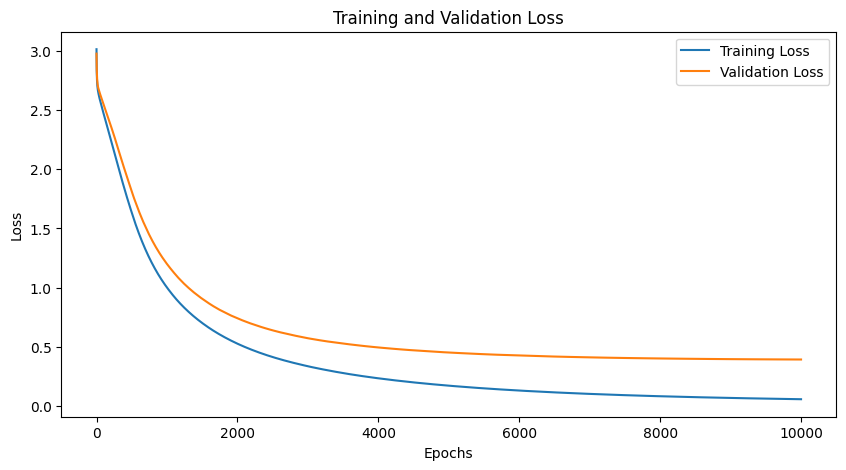

In [96]:
model_30.plot_training_error(error_train, error_val)

In [97]:
y_pred = model_30.test(X_test, y_test)
print(f'X_Test shape: {X_test.shape}')
print(f'y_Test shape: {y_test.shape}')
print(f'y_Pred shape: {y_pred.shape}')

Test Error : 0.4443280992620423
X_Test shape: (208, 900)
y_Test shape: (208, 15)
y_Pred shape: (208, 15)


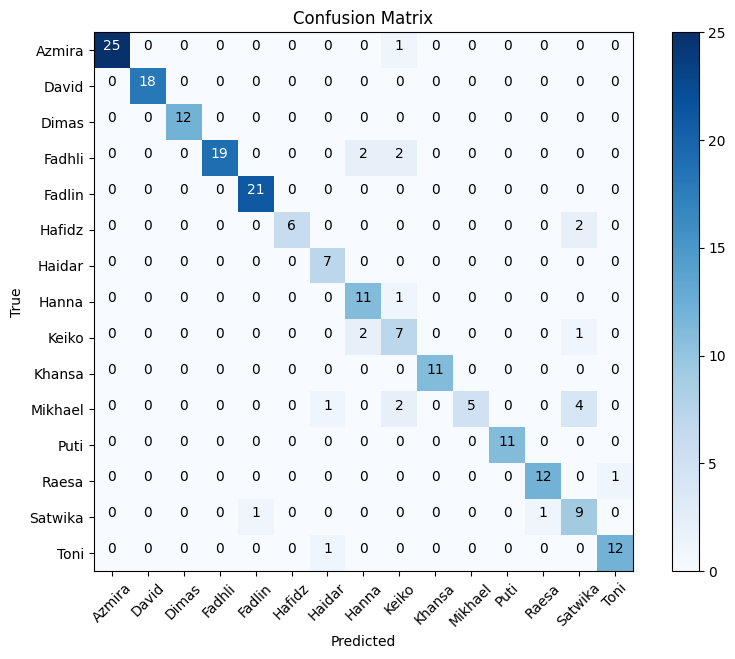

Accuracy: 0.8942307692307693
Azmira - Precision: 1.0, Recall: 0.9615384615384616, F1 Score: 0.9803921568627451
David - Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Dimas - Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Fadhli - Precision: 1.0, Recall: 0.8260869565217391, F1 Score: 0.9047619047619047
Fadlin - Precision: 0.9545454545454546, Recall: 1.0, F1 Score: 0.9767441860465117
Hafidz - Precision: 1.0, Recall: 0.75, F1 Score: 0.8571428571428571
Haidar - Precision: 0.7777777777777778, Recall: 1.0, F1 Score: 0.8750000000000001
Hanna - Precision: 0.7333333333333333, Recall: 0.9166666666666666, F1 Score: 0.8148148148148148
Keiko - Precision: 0.5384615384615384, Recall: 0.7, F1 Score: 0.608695652173913
Khansa - Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Mikhael - Precision: 1.0, Recall: 0.4166666666666667, F1 Score: 0.5882352941176471
Puti - Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Raesa - Precision: 0.9230769230769231, Recall: 0.9230769230769231, F1 Score: 0.9230769230769231
Satwika - Precis

In [98]:
model_30.add_labels_from_folders(input_path)
model_30.plot_confusion_matrix(X_test, y_test)
model_30.evaluate_metrics(X_test, y_test)